**<center><h1>Advanced Computer Vision for Artificial Intelligence Assignment</h1></center>**
**<center><h2>Part 3 - Object Detection Component (YOLOv5)</h2></center>**
**<center><h3>Matthias Bartolo, Jerome Agius, Isaac Muscat</h3></center>**

## This Notebook is Structure in the following manner:

- Required libraries
- Downloading the Roboflow datset
- Training the YOLOv5 model
- Testing the YOLOv5 model on the Testing subset
- Testing Results

In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalle

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 16114, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16114 (delta 8), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16114/16114), 14.79 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [3]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00


**<h3>Required libraries.</h3>**

In [49]:
import torch
import os
import yaml
import glob
import matplotlib.pyplot as plt
import yaml
import pandas as pd

from roboflow import Roboflow
from IPython.display import Image, display, clear_output
from utils.downloads import attempt_download

clear_output()

**<h3>Using GPU if one is available.</h3>**

In [5]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [6]:
# Retrieving the current working directory
HOME = os.getcwd()
print(HOME)

/content/yolov5


**<h3>Downloading the Roboflow dataset.</h3>**

In [7]:
rf = Roboflow(api_key="y2FfMokLpTlGQIlMvhja")
project = rf.workspace("advanced-computer-vision-assignment").project("pizza-object-detector")
dataset = project.version(7).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pizza-Object-Detector-7 in yolov5pytorch:: 100%|██████████| 6226/6226 [00:04<00:00, 1536.34it/s]


# **<h3>Defining the Model Configuration and Architecture.</h3>**

In [8]:
# define number of classes based on YAML
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate {HOME}/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

**<h3>Training the YOLOv5 model.</h3>**

In [11]:
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

2023-12-24 15:26:01.624421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 15:26:01.624492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 15:26:01.626448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 15:26:02.707324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Pizza-Object-Detector-7/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoa

**<h3>Validating the YOLOv5 model on the Validation subset.</h3>**

In [12]:
!python val.py --img 416 --batch 16 --data {dataset.location}/data.yaml --weights ./runs/train/yolov5s_results/weights/best.pt --name yolov5s_results

val: data=/content/yolov5/Pizza-Object-Detector-7/data.yaml, weights=['./runs/train/yolov5s_results/weights/best.pt'], batch_size=16, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolov5s_results, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7286973 parameters, 0 gradients, 16.9 GFLOPs
val: Scanning '/content/yolov5/Pizza-Object-Detector-7/valid/labels.cache' images and labels... 284 found, 0 missing, 0 empty, 0 corrupt: 100% 284/284 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/18 [00:00<?, ?it/s]WARNING: NMS time limit 0.780s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:

**<h3>Validating the YOLOv5 model on the Testing subset.</h3>**

In [39]:
# Function used to fix the data.yaml file as required by this code implementation
def fix_yaml_paths(file_path, test_path='Pizza-Object-Detector-7/test/images', train_path='Pizza-Object-Detector-7/train/images', val_path='Pizza-Object-Detector-7/valid/images'):
  try:
      with open(file_path, 'r') as file:
          data = yaml.safe_load(file)

      # Update the paths
      data['test'] = test_path
      data['train'] = train_path
      data['val'] = val_path

      with open(file_path, 'w') as file:
          yaml.dump(data, file, default_flow_style=False)

      print(f"YAML file '{file_path}' has been updated successfully.")
  except Exception as e:
      print(f"An error occurred: {e}")

# Function used to swap the val and test paths to carry out validation on the testing set
def swap_yaml_paths(file_path):
  try:
      with open(file_path, 'r') as file:
          data = yaml.safe_load(file)

      # Update the paths
      tmp = data['test']
      data['test'] = data['val']
      data['val'] = tmp

      with open(file_path, 'w') as file:
          yaml.dump(data, file, default_flow_style=False)

      print(f"YAML file '{file_path}' has been updated successfully.")
  except Exception as e:
      print(f"An error occurred: {e}")

In [40]:
fix_yaml_paths(dataset.location+'/data.yaml')

YAML file '/content/yolov5/Pizza-Object-Detector-7/data.yaml' has been updated successfully.


In [46]:
swap_yaml_paths(dataset.location+'/data.yaml')
!python val.py --img 416 --batch 16 --data {dataset.location}/data.yaml --weights ./runs/train/yolov5s_results/weights/best.pt --name yolov5s_results
swap_yaml_paths(dataset.location+'/data.yaml')

YAML file '/content/yolov5/Pizza-Object-Detector-7/data.yaml' has been updated successfully.
val: data=/content/yolov5/Pizza-Object-Detector-7/data.yaml, weights=['./runs/train/yolov5s_results/weights/best.pt'], batch_size=16, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolov5s_results, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7286973 parameters, 0 gradients, 16.9 GFLOPs
val: Scanning '/content/yolov5/Pizza-Object-Detector-7/test/labels.cache' images and labels... 283 found, 0 missing, 0 empty, 0 corrupt: 100% 283/283 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/18 [00:00<?, ?it/s]WARNING: NMS time limit 0.780s exce

**<h3>Testing the YOLOv5 model on the Testing subset.</h3>**


In [45]:
# import shutil

# def delete_directory(directory_path):
#     try:
#         shutil.rmtree(directory_path)
#         print(f"Directory '{directory_path}' has been successfully deleted.")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Example usage:
# directory_to_delete = '/content/yolov5/runs/val/yolov5s_results5'
# delete_directory(directory_to_delete)


Directory '/content/yolov5/runs/val/yolov5s_results5' has been successfully deleted.


In [47]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source Pizza-Object-Detector-7/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Pizza-Object-Detector-7/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7286973 parameters, 0 gradients, 16.9 GFLOPs
image 1/283 /content/yolov5/Pizza-Object-Detector-7/test/images/000001_jpg.rf.28a0a9ec43243edc5b2179d657363422.jpg: 256x416 1 Mushroom, 1 Pizza, Done. (0.050s)
image 2/283 /content/yolov5/Pizza-Object-Detector-7/test/images/00051_jpg.rf.46ae55e13d218643bc60a0bcd61b9745.jpg: 288x416 1 Basil, 2 Cheeses, 1 Piz

**<h3>Training Results.</h3>**

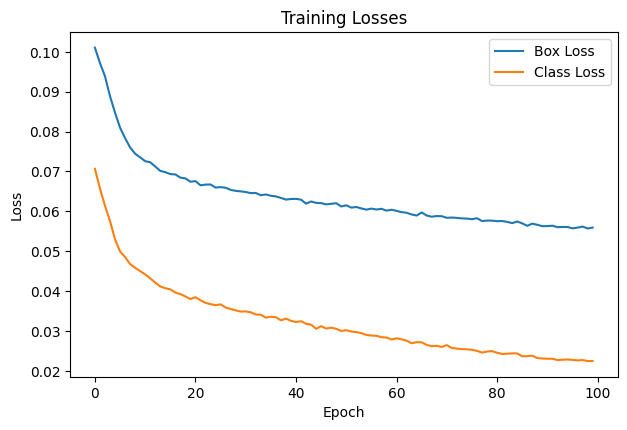

In [50]:
# Replace 'path/to/your/data.csv' with the actual path to your CSV file
file_path = '/content/yolov5/runs/train/yolov5s_results/results.csv'
column_name = 'epoch'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Remove leading spaces from column names
data.columns = data.columns.str.strip()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['train/cls_loss'], label='Class Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

**<h3>Validation Results.</h3>**

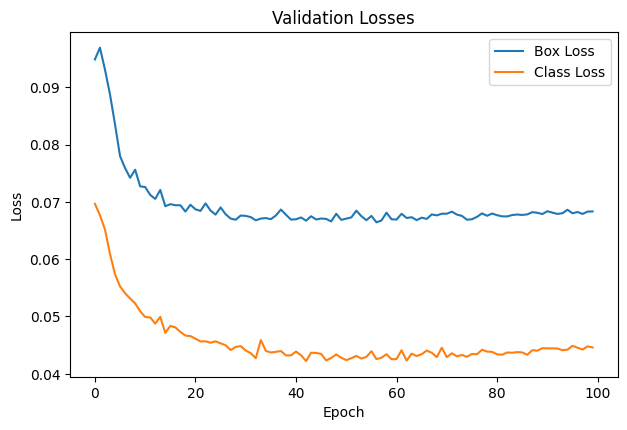

In [51]:
# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['val/cls_loss'], label='Class Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

**<h3>Testing Resultant Images.</h3>**

In [ ]:
for imageName in glob.glob(HOME + '/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")